# Complexity of Paillier Algorithms 

[A Comparison of El Gamal and Paillier
Cryptosystems](http://koclab.cs.ucsb.edu/teaching/cren/project/2018/Chen.pdf]) mentioned the time complexity of Paillier Algorithms:


![](figs/quote.png)

![](figs/table.png)

From the sencond column of table above, we see number of operations required inrease linearly with the increase of the size of plaintext.

## Experiments

In the setting of federated learning, there are few basic operations: 
* Encryption: $c = enc(x)$
* Decryption: $x =  dec(c)$
* Adding ciphertext with plaintext: $x + c$
* Adding ciphertext with ciphertext: $c_1 + c_2$
* Multiply a ciphertext with a plaintext: $cx$



In [70]:
!cat /proc/cpuinfo | grep 'model name' | uniq

model name	: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz


Implementation: [python-paillier](https://github.com/data61/python-paillier)

In [58]:
import phe
import numpy as np

def encrypt_array(public_key:phe.PaillierPublicKey, x:np.array):
    h, w = x.shape[0], x.shape[1]
    c = [public_key.encrypt(float(item)) for item in x.flatten()]
    c = np.array(c).reshape(h, w)
    return c 

def decrypt_array(private_key:phe.PaillierPrivateKey, c:np.array):
    h, w = c.shape[0], c.shape[1]
    x = [private_key.decrypt(item) for item in c.flatten()]
    x = np.array(x).reshape(h, w)
    return x    

def cipher_add(c1, c2):
    return c1 + c2
    
def cipher_plain_add(c, x):
    return c+x

def cipher_plain_mul(c, a):
    return a * c

In [59]:
from phe import paillier
KEY_SIZE = 128
pubkey, prikey = paillier.generate_paillier_keypair(n_length=KEY_SIZE)
x = np.array([1]*9).reshape(3, 3)
print(x)
c = encrypt_array(pubkey, x)
c = cipher_add(c, c)
c = cipher_plain_add(c, np.eye(3, 3))
c = cipher_plain_mul(c, 2)
decrypted_x = decrypt_array(prikey, c)
print(decrypted_x)

[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[6. 4. 4.]
 [4. 6. 4.]
 [4. 4. 6.]]


We fix the key dimension and see how the time required of 5 basic operations varies when we increase the size of plaintext

In [61]:
import time
def timeit(method, num_trails, *args, **kwargs):
    start = time.time()
    for _ in range(num_trails):
        res = method(*args, **kwargs)
    used_time = time.time() - start
    return used_time, res

In [64]:
import time
feat_sizes = [10, 50, 100, 250, 500, 1000]
NUM_SAMPLES = 100
NUM_TRAILS = 5 
record = []
for feat_size in feat_sizes:
    print(f"Samples #{NUM_SAMPLES} | Feature Size {feat_size}")
    x = np.random.randn(NUM_SAMPLES, feat_size)
    enc_time, c = timeit(encrypt_array, NUM_TRAILS, pubkey, x)
    c_add_time, _ = timeit(cipher_add, NUM_TRAILS, c, c)
    p_add_time, _ = timeit(cipher_plain_add, NUM_TRAILS, c, x)
    p_mul_time, _ = timeit(cipher_plain_mul, NUM_TRAILS, c, 3)
    dec_time, _ = timeit(decrypt_array, NUM_TRAILS, prikey, c)
    record.append([feat_size, enc_time, c_add_time, p_add_time, p_mul_time, dec_time])


Samples #100 | Feature Size 10
Samples #100 | Feature Size 50
Samples #100 | Feature Size 100
Samples #100 | Feature Size 250
Samples #100 | Feature Size 500
Samples #100 | Feature Size 1000


In [65]:
import pandas as pd
df = pd.DataFrame(record, columns=[
    'feature size', 
    'encryption time',
    'c + c time',
    'c + x time',
    'c * x time',
    'decryption time'
])

In [72]:
df['Total'] = df.sum(axis=1)
df

,feature size,encryption time,c + c time,c + x time,c * x time,decryption time,Total
0,10,0.603065,0.014551,0.118330,0.024570,0.297539,11.058055
1,50,3.018854,0.074289,0.625760,0.134737,1.639590,55.493230
2,100,6.342592,0.123240,1.143241,0.462100,2.754181,110.825354
3,250,13.700213,0.275990,2.896023,0.804470,6.682265,274.358961
4,500,26.775391,0.955021,5.485407,1.370756,13.549033,548.135608
5,1000,54.089990,1.863433,10.803079,2.892955,26.988481,1096.637938


Text(0, 0.5, 'Time for 5 run(sec)')

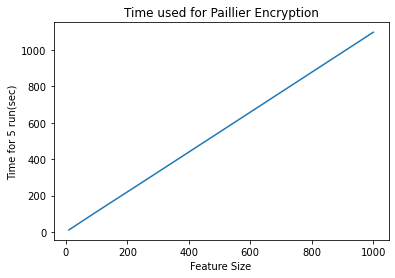

In [74]:
df.to_csv('paillier-time-complexity.csv')
import matplotlib.pyplot as plt 
plt.plot(df['feature size'], df['Total'])
plt.title('Time used for Paillier Encryption')
plt.xlabel('Feature Size')
plt.ylabel('Time for 5 run(sec)')